In [1]:
import pandas as pd
counts = pd.read_csv("data/Fremont_Bridge_Bicycle_Counter.csv", index_col="Date", parse_dates=True)
weather = pd.read_csv("data/BicycleWeather.csv", index_col="DATE", parse_dates=True)

In [2]:
counts.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


In [3]:
weather[:2]

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999


In [4]:
daily = counts.resample("d").sum()
daily["Total"] = daily.sum(axis=1)
daily = daily[["Total"]]
# no hay datos de precipitacion luego de mayo 2014 en el dataset de weather
daily = daily[:"2015-5"]

In [5]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [6]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays("2012", "2016")
daily = daily.join(pd.Series(1, index=holidays, name="holiday"))
daily["holiday"] = daily["holiday"].fillna(0)

In [8]:
daily.head(6)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-08,7074.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
import numpy as np
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Daylight hours for given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
        * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.



In [10]:
daily["daylight_hrs"] = list(map(hours_of_daylight, daily.index))
daily["daylight_hrs"].plot();

In [11]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs
Date,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208


In [12]:
weather["TMIN"] /= 10
weather["TMAX"] /= 10
weather["Temp (C)"] = 0.5 * (weather["TMIN"] + weather["TMAX"])

weather["dry day"] = (weather["PRCP"] == 0).astype(int)

In [13]:
daily = daily.join(weather[["PRCP", "Temp (C)", "dry day"]])

In [14]:
daily.head(20)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0,13.35,1
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0,13.60,1
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0,15.30,1
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0,15.85,1
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0,15.85,1
2012-10-08,7074.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.987503,0,14.45,1
2012-10-09,7002.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.929950,0,12.50,1
2012-10-10,6470.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.872560,0,10.25,1
2012-10-11,6094.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.815345,0,10.55,1


In [15]:
daily["annual"] = (daily.index - daily.index[0]).days / 365.
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0,13.35,1,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0,13.60,1,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0,15.30,1,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0,15.85,1,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0,15.85,1,0.010959


In [22]:
# revisar si hay Nan antes de fitear el modelo
daily[daily.isnull().any(axis=1)]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,


In [16]:
from sklearn.linear_model import LinearRegression

column_names = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun", 
                "holiday", "daylight_hrs", "PRCP", "Temp (C)", 
                "dry day", "annual"]
X = daily[column_names]
y = daily["Total"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily["predicted"] = model.predict(X)

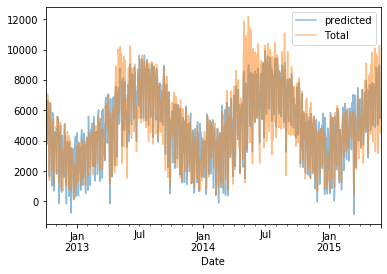

In [23]:
daily[["predicted", "Total"]].plot(alpha=0.5)

In [25]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              807.438753
Tue              959.748149
Wed              918.408231
Thu              711.906714
Fri              153.111859
Sat            -2335.624689
Sun            -2409.814578
holiday        -2302.232290
daylight_hrs     253.609836
PRCP              -5.268074
Temp (C)         144.042831
dry day         1102.743912
annual           155.233064
dtype: float64

In [27]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [29]:
pd.DataFrame({"effect": params.round(0), "err": err.round(0)})

,effect,err
Mon,807.0,181.0
Tue,960.0,175.0
Wed,918.0,173.0
Thu,712.0,185.0
Fri,153.0,174.0
Sat,-2336.0,180.0
Sun,-2410.0,179.0
holiday,-2302.0,325.0
daylight_hrs,254.0,19.0
PRCP,-5.0,0.0


In [38]:
from sklearn.model_selection import train_test_split

column_names = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun", 
                "holiday", "daylight_hrs", "PRCP", "Temp (C)", 
                "dry day", "annual"]
X = daily[column_names]
y = daily["Total"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

daily["predicted"] = model.predict(X)
model.score(X_test, y_test)

0.8685664519228127

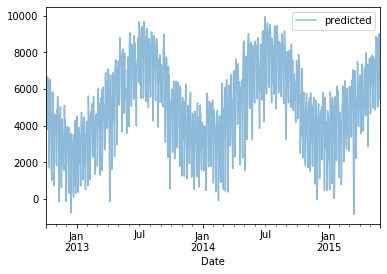

In [40]:
daily[["predicted"]].plot(alpha=0.5)

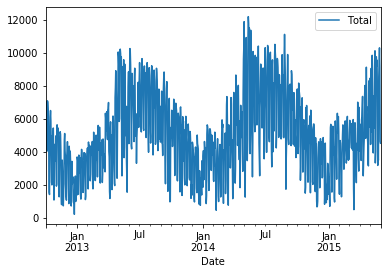

In [42]:
daily[["Total"]].plot()